In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

import gc

from os import path
import sys
sys.path.append(path.abspath('..'))

In [5]:
import os
import cv2
import torch
import pandas as pd
from PIL import Image
from pprint import pprint
import albumentations as albu
from albumentations.pytorch import ToTensorV2

from src.lightning_module import PosterModule

In [6]:
DEVICE = 'cuda:0'

In [8]:
# Загружаем модель

checkpoint_name = '../experiments/resnet34/epoch_epoch=12-val_f1=0.612.ckpt'
module = PosterModule.load_from_checkpoint(checkpoint_name)

_ = module.eval()
_ = module.to(DEVICE)

In [9]:
# Загружаем данные
df = pd.read_csv( '../data/df_test.csv')
names = list(df.columns[1:])
names
df.head()

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

,image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,train_5,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
2,train_9,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0
3,train_12,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,train_19,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0


In [10]:
# препроцессинг данных 
img_height = 224
img_width = 224
preprocess = albu.Compose(
        [
            albu.Resize(height=img_height, width=img_width),
            albu.Normalize(),
            ToTensorV2(),
        ]
)

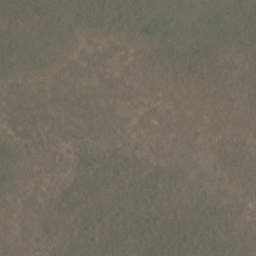

In [30]:
idx = 10
image_name = os.path.join('../data', 'train-jpg', f'{df["image_name"][idx]}.jpg')
image = cv2.imread(image_name)[..., ::-1]
Image.fromarray(image)

In [31]:
procecces_image = preprocess(image=image)['image']
with torch.no_grad():
    scores = torch.sigmoid(module(procecces_image[None].to(DEVICE)))[0].cpu().numpy()
    
pprint({n:s for s, n in zip(scores, names)})

{'agriculture': 0.6599332,
 'artisinal_mine': 0.00038826987,
 'bare_ground': 0.30170968,
 'blooming': 0.00046818546,
 'blow_down': 0.004192255,
 'clear': 0.6071317,
 'cloudy': 0.007208566,
 'conventional_mine': 0.00059870846,
 'cultivation': 0.11288054,
 'habitation': 0.007935757,
 'haze': 0.4208962,
 'partly_cloudy': 0.003335886,
 'primary': 0.87334406,
 'road': 0.05126983,
 'selective_logging': 0.0013294163,
 'slash_burn': 0.008913961,
 'water': 0.05541129}
